In [8]:
import os as os
from dateutil.relativedelta import relativedelta, TH
import pandas_datareader.data as web
import datetime as dt    
import pandas as pd
import numpy as np
import random as rd


%pylab inline

execfile("./parser/sec_crawler.py")

Populating the interactive namespace from numpy and matplotlib


In [16]:
def read_file(file_name):
    try :
        with codecs.open(file_name,'rb',encoding='utf-8') as fin:
             text = fin.read()
             fin.close()
             return text   
    except IOError:
        print file_name + ' not found'
        return 0
        
def get_words_from_string(text):
    lines = text.split("\n")
    lines = [ x.strip() for x in lines if len(x) > 0]
    lines = [ x.split(" ") for x in lines if len(x) > 0]
                
    words = []
    for line in lines:
        for tw in line:
            words.append(tw)
    words = [ i for i in words if len(i) > 3]            
    return words
        


In [105]:
def similarity_score_word_count(curr_file, prev_file ):
        curr_text = read_file(curr_file)
        prev_text = read_file(prev_file)
        score = 0.0
        msg = True
        
        if ( curr_text == 0 ) or ( prev_text == 0) :
            msg = False
            return score, msg
        else :
            curr_words = get_words_from_string(curr_text)
            prev_words = get_words_from_string(prev_text)

            if len(prev_words ) ==0  or len(curr_words) == 0:
                msg = False
                return score, msg
            else:
                score =  - ( abs( (len(prev_words)*1.0) - (len( curr_words)*1.0) )/ len(prev_words)*1.0 )
                msg = True
                return score, msg
def similarity_score_word_vec(curr_file, prev_file ):

    curr_vec = np.load(curr_file+'.npy')
    prev_vec = np.load(prev_file+'.npy')

    if curr_vec.shape[0] == 0 or prev_vec.shape[0] == 0 :
        return 0.0, False
    
    try :
      score =  np.corrcoef(curr_vec.mean(axis=0), prev_vec.mean(axis=0))[0,1]
      msg = True
      return score, msg  
    except :
        print curr_file
        print prev_file
        print '----------'
        return 0.0, False
                        

In [88]:
def get_10k_sec_file(ticker, sec_dir, curr_year):
    this_dir = '../data/10-K/' + ticker + '/' + sec_dir + '/'
    file_names = os.listdir(this_dir)
    file_names = [ i for i in file_names if not '.swp' in i]
    file_names = [ i.split('.')[0] for i in file_names ]
    
    file_dates = [ dt.datetime.strptime(i, '%Y-%m-%d') for i in file_names ]
    #file_dates = np.array(file_dates)
    #sort_ind = file_dates.argsort()
    
    file_ind = [ i for i in range(len(file_names)) if (file_dates[i]).year == curr_year ]
    
    if len(file_ind) > 0:
        return '../data/10-K/' + ticker + '/' + sec_dir + '/' + file_names[file_ind[0]], True

    else :
        return 0, False
def similarity_score_10k_generic(ticker , sec_dir, score_func, curr_year = 2015 ):
    prev_year = dt.datetime(curr_year, 1, 1).year - 1
    curr_file, curr_file_msg = get_10k_sec_file(ticker, sec_dir, curr_year)
    prev_file, prev_file_msg = get_10k_sec_file(ticker, sec_dir, prev_year)
    
    if ( curr_file_msg ) and ( prev_file_msg ):
        score, score_msg = score_func(curr_file, prev_file)
    else :
        score, score_msg = 0.0, False
    
    return score, score_msg

In [97]:
#get_10k_sec_file('GS', 'TEXT_VW', 2015)
similarity_score_10k_generic('GS', 'TEXT_VW', similarity_score_word_vec, 2015)


(0.99998381758352062, True)

In [83]:
def long_short_quantile_weights( scores, quantile = 0.1 ):
    weights = np.zeros(len(scores))
    ind_true = [ i for i in range(len(scores)) if scores[i][1] ]
    ind_false = [ i for i in range(len(scores)) if not scores[i][1] ]

    scores_true = [ (scores[i][0], i) for i in ind_true ]
    scores_true = sorted(scores_true, key=lambda l:l[0])
    quantile_weights = np.zeros(len(scores_true))
    q1_ind = range( int( len(quantile_weights)*quantile) )
    quantile_weights[q1_ind] = -1.0/( len(q1_ind)*1.0 )
    
    q2_ind = range( -(int( len(quantile_weights)*quantile) ), 0 )
    quantile_weights[q2_ind] = 1.0/( len(q2_ind)*1.0 )
    
    for  i, x in enumerate(scores_true) :
        weights[x[1]] = quantile_weights[i]
    
    
    return weights
    #scores_mean = scores_true.mean(axis=0)[0]
    #scores_std = 
    
    
def long_short_z_cs_weights( scores, quantile = 0.1 ):
    weights = np.zeros(len(scores))
    ind_true = [ i for i in range(len(scores)) if scores[i][1] ]
    ind_false = [ i for i in range(len(scores)) if not scores[i][1] ]

    scores_true = [ (scores[i][0], i) for i in ind_true ]
    scores_true = sorted(scores_true, key=lambda l:l[0])
    scores_true_np = np.array(scores_true)
    
    z_cs_weights = np.zeros(len(scores_true))
    cs_m = scores_true_np.mean(axis=0)[0]
    cs_std = scores_true_np.std(axis=0)[0]
    z_cs_weights = [ (x[0] - cs_m)/cs_std for x in scores_true ]
    
    print np.array(z_cs_weights).shape
    print cs_m, cs_std
    
    for  i, x in enumerate(scores_true) :
        weights[x[1]] = z_cs_weights[i]
    
    
    return weights


def get_prices_df(tickers, begin_year, end_year):
    df = pd.DataFrame()
    
    begin_date = dt.datetime(begin_year,1,1)
    end_date = dt.datetime(end_year,12,30)

    for tic in tickers:
        p = web.DataReader(tic, 'yahoo', begin_date, end_date).Close
        df[tic] = p
    df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    return df 

def get_ticker_ret( ticker, year, horizon, df):
    start_date = get_10k_sec_file(ticker, 'TEXT', year)[0]
    start_date = start_date.split("/")[-1]
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = start_date + relativedelta(months=horizon)
    
    curr_price = (df[ticker]).iloc[df.index.get_loc(start_date,method='nearest')]
    fut_price = (df[ticker]).iloc[df.index.get_loc(end_date,method='nearest')]
    this_ret = ( fut_price - curr_price )/ curr_price
      
    return this_ret

def run_strategy(tickers, begin_year, end_year, sec_dir, score_func, weights_func, horizon ):
    years_range = []
    begin_year_dt = dt.datetime(begin_year, 1, 1)
    curr_year_dt = begin_year_dt
    end_year_dt = dt.datetime(end_year, 12, 30)
    
    df = get_prices_df(tickers, ( begin_year_dt + relativedelta(years=-2) ).year, ( end_year_dt + relativedelta(years=2) ).year)
    pnl_vec = [] 
    while curr_year_dt <= end_year_dt:
        years_range.append(curr_year_dt.year)
        curr_year_dt = curr_year_dt +relativedelta(years=1)

   
    for curr_year in years_range:
        f = lambda(tic) : similarity_score_10k_generic(tic , sec_dir, score_func, curr_year  )
        scores = [f(tic) for tic in tickers ]
        weights = weights_func(scores)
        ret_vec = np.zeros(len(scores))

        for i, x in enumerate(scores):
            if x[1] :
                r = get_ticker_ret(tickers[i],curr_year, horizon, df)
                ret_vec[i] = r
        
        curr_pnl =    np.dot(weights, ret_vec)
        pnl_vec.append(curr_pnl)
   
    return pnl_vec

In [109]:
#tickers = next(os.walk('../data/10-K/'))[1]
#pnl_vec = run_strategy(tickers, 2005, 2015, 'TEXT', similarity_score_word_count, long_short_quantile_weights, 12 )


In [126]:
tickers = next(os.walk('../data/10-K/'))[1]
pnl_vec_zcs = run_strategy(tickers, 2005, 2014, 'TEXT', similarity_score_word_count, long_short_z_cs_weights, 12 )


(28,)
-0.277963915668 0.475778258262
(28,)
-1.1300506757 4.87295079923
(28,)
-0.181194751034 0.379693681929
(28,)
-2.56743548107 9.0715809296
(28,)
-0.351466561031 0.980593484696
(28,)
-0.223386316419 0.686322857122
(27,)
-0.178587280372 0.397825947388
(27,)
-0.717135683771 2.73361114702
(27,)
-6.55093248573 33.1542798026
(27,)
-41.4353023696 211.079670976


In [110]:
#tickers = next(os.walk('../data/10-K/'))[1]
#pnl_vec_zcs_vw = run_strategy(tickers, 2005, 2015, 'TEXT_VW', similarity_score_word_vec, long_short_z_cs_weights, 12 )


In [130]:
np.array(pnl_vec_zcs).mean()/np.array(pnl_vec_zcs).std()

-0.1727997189366654

In [112]:
def get_10_k_all(ticker = "GS", start_date = dt.datetime(2005,1,1),final_date = dt.datetime(2014,12,31) ):
    this_dir =  "../data/10-K/" + ticker+"/TEXT/"
    file_names = os.listdir(this_dir)
    file_names = [ i for i in file_names if not '.swp' in i]
    content_dict = {}
    for i in file_names: 
        f = open(this_dir+i)
        f_d = dt.datetime.strptime(i, '%Y-%m-%d')
        if ( f_d < final_date ) and ( f_d > start_date ) :
             content = f.readlines()
             content_dict[f_d] = content
  
    return content_dict



    


In [131]:
def get_ticker_signal_ret(ticker = 'GS', time_horizon = 12 ):

    data_dic = get_10_k_all(ticker) 
    f_dates = data_dic.keys()    
    f_dates.sort()
    
    last_text = data_dic[f_dates[0]]
    signal_vec = []
    
    start = f_dates[1]
    end = f_dates[-1] +  relativedelta(months = time_horizon)
    end = min( end, dt.datetime.today() + relativedelta(days = -3))
    price_data = web.DataReader(ticker, 'yahoo', start, end)
    ret_vec = []
    
    for i in range(1, len(f_dates)):
        f_d = f_dates[i]
            
        fut_date = f_d + relativedelta(months = time_horizon)
        this_text = data_dic[f_d]
        words_diff = abs( len(this_text) - len(last_text) )/( len(last_text) *1.0)
        signal_vec.append(words_diff)
        curr_price = price_data.iloc[price_data.index.get_loc(f_d,method='nearest')].Open
        fut_price = price_data.iloc[price_data.index.get_loc(fut_date,method='nearest')].Open
        this_ret = ( fut_price - curr_price )/ curr_price
        ret_vec.append(this_ret)
    
    this_data = {"signal":signal_vec, "ret":ret_vec}
    return this_data

def get_all_tickers_signal_ret(time_horizon = 12):
    tickers = next(os.walk('../data/10-K/'))[1]
    
    signals_df = pd.DataFrame()
    ret_df = pd.DataFrame()

    tic = tickers[0]
    this_data = get_ticker_signal_ret(ticker=tic,time_horizon = time_horizon)
    signals_df[tic] = this_data['signal']
    ret_df[tic] = this_data['ret']
    
    for tic in tickers[1:]:
        this_data = get_ticker_signal_ret(ticker=tic,time_horizon = time_horizon)
        if signals_df.shape[0] == len(this_data['signal']):
            signals_df[tic] = this_data['signal']
            ret_df[tic] = this_data['ret']

    return {'signal': signals_df, 'ret':ret_df}

        
def get_ticker_cor( ticker = 'GS', time_horizon = 12):
    data_dic = get_10_k_all(ticker) 
    f_dates = data_dic.keys()    
    f_dates.sort()
    
    last_text = data_dic[f_dates[0]]
    signal_vec = []
    
    start = f_dates[1]
    end = f_dates[-1] +  relativedelta(months = time_horizon)
    end = min( end, dt.datetime.today() + relativedelta(days = -3))
    price_data = web.DataReader(ticker, 'yahoo', start, end)
    ret_vec = []
    
    for i in range(1, len(f_dates)):
        f_d = f_dates[i]
        fut_date = f_d + relativedelta(months = time_horizon)
        this_text = data_dic[f_d]
        words_diff = abs( len(this_text) - len(last_text) )
        last_text = this_text
        signal_vec.append(words_diff)
        curr_price = price_data.iloc[price_data.index.get_loc(f_d,method='nearest')].Open
        fut_price = price_data.iloc[price_data.index.get_loc(fut_date,method='nearest')].Open
        this_ret = ( fut_price - curr_price )/ curr_price
        ret_vec.append(this_ret)
    
    cor = np.corrcoef(signal_vec,ret_vec)[0][1]
    return cor

In [132]:

tickers = next(os.walk('../data/10-K/'))[1]

In [115]:
#tickers = [ 'AAPL', 'AMZN', 'GS', 'INTC', 'JPM', 'MS', 'MSFT', 'NVDA']
cor_vec = []
for tic in tickers:
     this_cor = get_ticker_cor(tic)
     cor_vec.append(this_cor)   


In [116]:
cor_df = pd.DataFrame()
cor_df['ticker']  = tickers
cor_df['correlation'] = cor_vec

In [138]:
df = get_all_tickers_signal_ret()


In [133]:
def test_long_short_0 (data):
    rd.seed(12345)

    signals = data['signal']
    ret = data['ret']
    pnl_series = [1.0]
    curr_pnl = 1.0
    ret_series = []
    
    for i in range(signals.shape[0]):
        curr_signal = signals.iloc[i,]
        weights = np.zeros(signals.shape[1])
        ind = rd.sample(range(signals.shape[1]), 10)
        weights[ind[-5:]] = 1.0
        weights[ind[0:5]] = -1.0

        curr_ret = sum( ret.iloc[i,]*weights )
        ret_series.append(curr_ret)
        curr_pnl = curr_pnl+ curr_ret
        pnl_series.append(curr_pnl)
        
    return pnl_series, ret_series    

def test_long_short_1 (data):
    signals = data['signal']
    ret = data['ret']
    pnl_series = [1.0]
    curr_pnl = 1.0
    ret_series = []
    
    for i in range(signals.shape[0]):
        curr_signal = signals.iloc[i,]
        ind = curr_signal.argsort()
        weights = np.zeros(len(ind))
        weights[ind[-5:]] = -1.0
        weights[ind[0:5]] = 1.0

        curr_ret = sum( ret.iloc[i,]*weights )
        ret_series.append(curr_ret)
        curr_pnl = curr_pnl+ curr_ret
        pnl_series.append(curr_pnl)
        
    return pnl_series, ret_series    

def test_long_short_2 (data):
    signals = data['signal']
    ret = data['ret']
    pnl_series = [1.0]
    curr_pnl = 1.0
    ret_series = []
    
    for i in range(signals.shape[0]):
        curr_signal = signals.iloc[i,]
        z_scores = ( curr_signal - curr_signal.mean() ) / curr_signal.std()
        weights = -z_scores

        curr_ret = sum( ret.iloc[i,]*weights )
        ret_series.append( curr_ret )
        curr_pnl = curr_pnl + ( curr_ret)
        pnl_series.append(curr_pnl)
        
    return pnl_series, ret_series    


### Long Short Portfolio using quantile approach

In [139]:
dates = [dt.datetime(2004,1,1) + relativedelta(years=i) for i in range(10) ]

In [140]:

pnl_series_1, ret_series_1 = test_long_short_0(df)
mean_ret = np.mean(ret_series_1)
std_ret = np.std(ret_series_1)
sharpe_ratio = mean_ret/std_ret
print 'sharpe ratio = ' + str(sharpe_ratio)

sharpe ratio = -0.578540737147


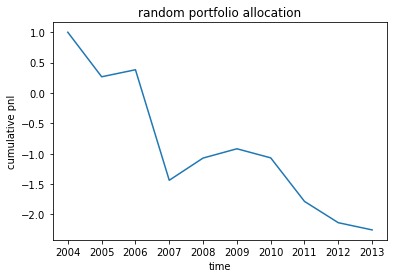

In [141]:
plot(dates, pnl_series_1)
pylab.xlabel('time')
pylab.ylabel('cumulative pnl')
pylab.title('random portfolio allocation')

In [142]:

pnl_series_1, ret_series_1 = test_long_short_1(df)
mean_ret = np.mean(ret_series_1)
std_ret = np.std(ret_series_1)
sharpe_ratio = mean_ret/std_ret
print 'sharpe ratio = ' + str(sharpe_ratio)


sharpe ratio = 0.0184817396542


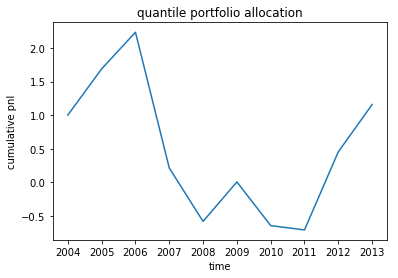

In [143]:
plot(dates, pnl_series_1)
pylab.xlabel('time')
pylab.ylabel('cumulative pnl')
pylab.title('quantile portfolio allocation')

### Long Short portfolio using alpha forcast approch

In [144]:
pnl_series_1, ret_series_1 = test_long_short_2(df)
mean_ret = np.mean(ret_series_1)
std_ret = np.std(ret_series_1)
sharpe_ratio = mean_ret/std_ret
print 'sharpe ratio = ' + str(sharpe_ratio)



sharpe ratio = 0.342457454577


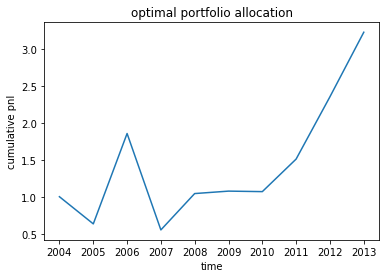

In [145]:
plot(dates,pnl_series_1)
pylab.xlabel('time')
pylab.ylabel('cumulative pnl')
pylab.title('optimal portfolio allocation')

In [ ]:
import random
random.seed(10)
random.sample(range(signals.shape[1]), 10)